# Analyze the 1000 Genome Mosaic Outputs
Idea: Analyse a large number of samples together, and prepare summary plots.

This codes assumes that the Simulation as well as the HMM Calling has been done, and that the files have been saved according to the guidelines. This code here loads these files, post-process them and provides summary level statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Notebooks/Mosaic1000G_Analysis/mosaic_test/")  # Assume we are in Hapsburg Root Directory
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

from load_funcs import Summary_ROH_Calls, Summary_ROH_Calls_Error, Summary_ROH_Calls_Missing, \
                        statistics_power_df, calc_power, give_SE,\
                       false_power_statistics, return_calls_only, give_bias, false_positive_nrs
from plot_funcs import plot_power, plot_fp_distribution

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [24]:
bl_lens = [2, 4, 6, 8, 10]   # The Length of the Blocks


### Extract the Pandas Dataframes for called blocks
df_call_vec = [collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = l, output_prefix="ROHin10/") 
            for l in bl_lens]

powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting

###########################
ses = [give_SE(df) for df in df_call_vec1]
bias = [give_bias(df_call_vec1[i], bl_lens[i]) for i in range(len(bl_lens))]

print("Standard Errors:")
print(ses)

print("Biases:")
print(bias)

Standard Errors:
[0.42333273924268167, 0.4781977540482479, 0.3757196592178983, 0.47278934045834486, 0.44050553775379375]
Biases:
[0.19401742399999877, 0.18881508799999924, 0.16879123799999984, 0.21679731800000113, 0.15682484400000085]


# Figures

### With Gaps Merged

## False Positive Plot

### Example Application

In [5]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/YRI/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "allRef/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics

Found 44 FP blocks
Average Block length: 0.0116 cM
Maximum Block length: 0.0175 cM


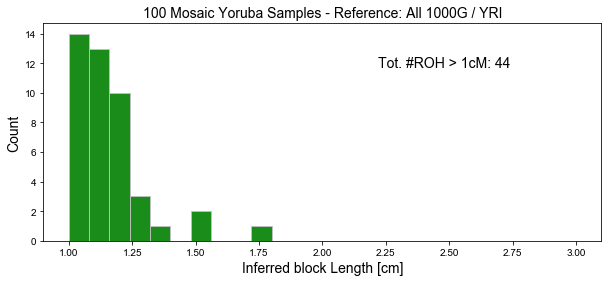

In [6]:
plot_fp_distribution(df_call_fp, title = "100 Mosaic Yoruba Samples - Reference: All 1000G / YRI")

Found 0 FP blocks


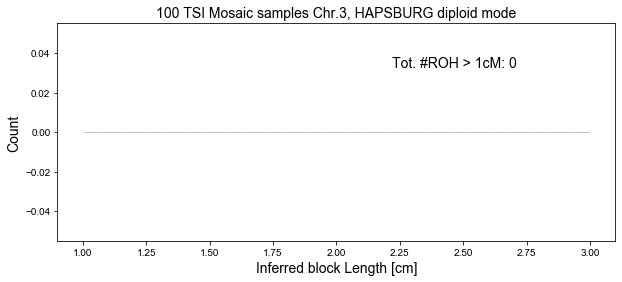

In [7]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "diploidGT/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, HAPSBURG diploid mode")

Found 1361 FP blocks
Average Block length: 0.0029 cM
Maximum Block length: 0.0128 cM


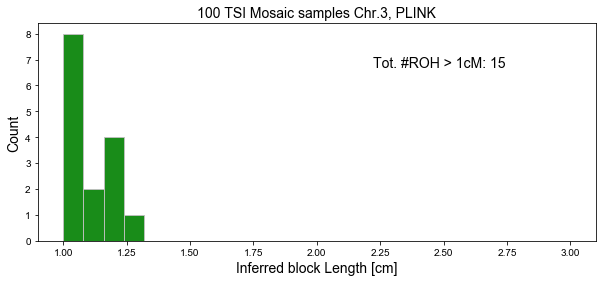

In [8]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "plink/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, PLINK")

Found 3565 FP blocks
Average Block length: 0.0025 cM
Maximum Block length: 0.0150 cM


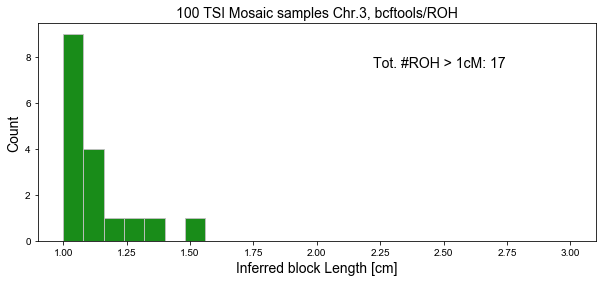

In [9]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "bcftools/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, bcftools/ROH")

## Output Full Set of Analysis per Run
Requires all Blocks lengths run for all individuals
Rerun the Cell below

In [6]:
def show_full_results(roh, bl_lens = [2, 4, 6, 8, 10], pw_lens=[1,2,3,4], bl_focus = 4, title="", 
                      savepath="", figsize=(10,6), ch3_len=2.232549, nr_iid=100, xlim=(0, 12.5)):
    """Show Full range of results: Statistic for bl_focus, Power Curve for all b_lens, FP-Rate.
    roh: ROH Object, which has the parameters for the folder set
    pw_lens: Lenghts for False Positive cutoffs.
    savepath: If given, save the overview Figure to there.
    ch3_len: Length of Chromosome 3 to calculate FP rate per cM [given in Morgan]"""
    ###### 1) Do the statistics
    roh.blen_cm = bl_focus
    df_calls = roh.collect_power_df()
    statistics_power_df(df_calls)

    ###### Statistics
    df1 = return_calls_only(df_calls)
    ses = give_SE(df1)
    bias = give_bias(df1, bl_focus)

    print(f"Statistics for BL Lengths: {bl_focus}")
    print(f"Standard Error: {ses:.4f}")
    print(f"Bias: {bias:.4f}")

    ###### 2) Do the Power Plot
    df_call_vec, df_called, power = roh.give_power_dfs(bl_lens)
    plot_power(bl_lens, df_called, power, savepath=savepath, title=title, 
               xlim=xlim, figsize=figsize)
    print("Analysis Complete")
    
    ###### 3) Do the FP Plot:
    roh.blen_cm = 0 # Set to 0
    df_call_fp = roh.collect_fp_df()
    #false_power_statistics(df_call_fp)  # Do give some written statistics
    fp_vec = false_positive_nrs(df_call_fp, pw_lens)
    
    for i in range(len(pw_lens)):
        print(f"FP Blocks > {pw_lens[i]} cM: {fp_vec[i]}")
        print(f"Rate per cM: {fp_vec[i]/(ch3_len*100*nr_iid)}")

Total Nr Simulated: 500
Total Nr Called: 678
100 unique Individuals
500 / 500 Blocks called
489 Blocks called > 80.0 %
4.0695 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.4646
Bias: 0.0695
Total Nr Simulated: 500
Total Nr Called: 685
Total Nr Simulated: 500
Total Nr Called: 678
Total Nr Simulated: 500
Total Nr Called: 677
Total Nr Simulated: 500
Total Nr Called: 655
Total Nr Simulated: 500
Total Nr Called: 677


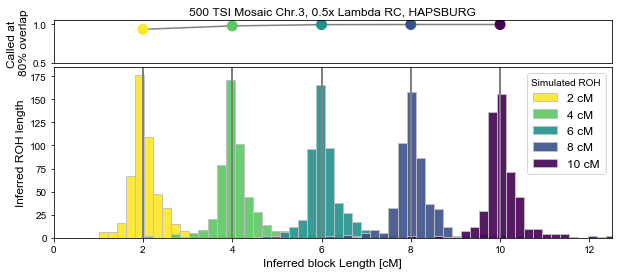

Analysis Complete
FP Blocks > 1 cM: 228
Rate per cM: 0.010212541807593024
FP Blocks > 2 cM: 6
Rate per cM: 0.00026875110019981645
FP Blocks > 3 cM: 2
Rate per cM: 8.958370006660547e-05
FP Blocks > 4 cM: 0
Rate per cM: 0.0


In [16]:
output_prefix = "allref/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
#mosaic_folder = "./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc0.5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(10,4),
                  title="500 TSI Mosaic Chr.3, 0.5x Lambda RC, HAPSBURG", savepath="")

## Test different target populations [Supp. Fig.]
Enter TSI, CHB, CLM & YRI

In [ ]:
output_prefix = "allRef/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(10,4),
                  title="100 CHB Mosaic Individuals", savepath="")  #./figures/manuscript/supplement/var_target_pops/clm.pdf

## Plot all 3 Methods on ideal 1240k Diploid Genotype Data [Supplemental Figure]

Total Nr Simulated: 500
Total Nr Called: 1745
100 unique Individuals
500 / 500 Blocks called
493 Blocks called > 80.0 %
4.1000 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.2290
Bias: 0.1000
Total Nr Simulated: 500
Total Nr Called: 1796
Total Nr Simulated: 500
Total Nr Called: 1745
Total Nr Simulated: 500
Total Nr Called: 1674
Total Nr Simulated: 500
Total Nr Called: 1602
Total Nr Simulated: 500
Total Nr Called: 1527


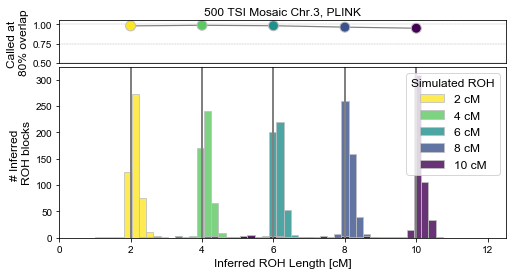

Analysis Complete
FP Blocks > 1 cM: 15
Rate per cM: 0.0006718777504995411
FP Blocks > 2 cM: 0
Rate per cM: 0.0
FP Blocks > 3 cM: 0
Rate per cM: 0.0
FP Blocks > 4 cM: 0
Rate per cM: 0.0


In [4]:
output_prefix = "plink/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(8,4),
                  title="500 TSI Mosaic Chr.3, PLINK", savepath="./figures/manuscript/supplement/diploidGT_mosaic/plink.pdf")

Total Nr Simulated: 500
Total Nr Called: 3516
100 unique Individuals
500 / 500 Blocks called
500 Blocks called > 80.0 %
4.0844 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.1552
Bias: 0.0844
Total Nr Simulated: 500
Total Nr Called: 3675
Total Nr Simulated: 500
Total Nr Called: 3516
Total Nr Simulated: 500
Total Nr Called: 3360
Total Nr Simulated: 500
Total Nr Called: 3199
Total Nr Simulated: 500
Total Nr Called: 3026


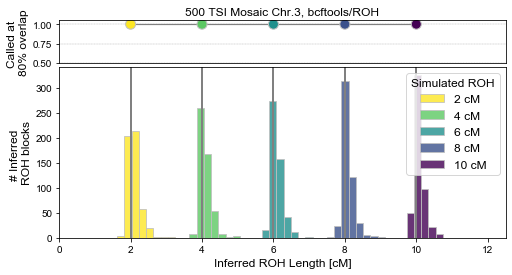

Analysis Complete
FP Blocks > 1 cM: 17
Rate per cM: 0.0007614614505661465
FP Blocks > 2 cM: 0
Rate per cM: 0.0
FP Blocks > 3 cM: 0
Rate per cM: 0.0
FP Blocks > 4 cM: 0
Rate per cM: 0.0


In [5]:
output_prefix = "bcftools/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(8,4),
                  title="500 TSI Mosaic Chr.3, bcftools/ROH", savepath="./figures/manuscript/supplement/diploidGT_mosaic/bcftools.pdf")

Total Nr Simulated: 500
Total Nr Called: 501
100 unique Individuals
500 / 500 Blocks called
497 Blocks called > 80.0 %
3.9978 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.1599
Bias: -0.0022
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 501


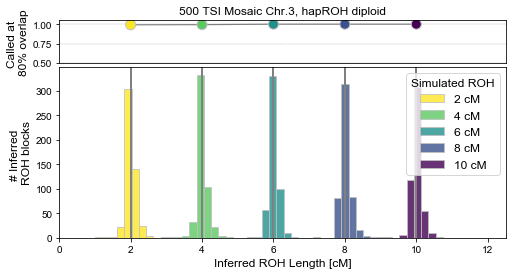

Analysis Complete
FP Blocks > 1 cM: 0
Rate per cM: 0.0
FP Blocks > 2 cM: 0
Rate per cM: 0.0
FP Blocks > 3 cM: 0
Rate per cM: 0.0
FP Blocks > 4 cM: 0
Rate per cM: 0.0


In [7]:
output_prefix = "diploidGT/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch = 3
nr_iid = 100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(8,4),
                  title="500 TSI Mosaic Chr.3, hapROH diploid", 
                  savepath="./figures/manuscript/supplement/diploidGT_mosaic/hapsburg.pdf")

In [ ]:
output_prefix = "bcftools/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/ph1.0/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, figsize=(8,4),
                  title="500 TSI Mosaic Chr.3 pseudohaploid, bcftools/ROH", savepath="")

### Single Parameter Results for Data with error

Showing Results for Error: 0.0268
Total Nr Simulated: 500
Total Nr Called: 558
100 unique Individuals
500 / 500 Blocks called
422 Blocks called > 80.0 %
3.7923 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.6267
Bias: -0.2077


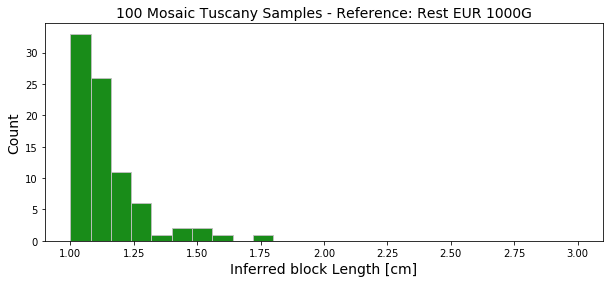

Found 83 FP blocks
Average Block length: 0.0114 cM
Maximum Block length: 0.0179 cM
Total Nr Simulated: 500
Total Nr Called: 550
Total Nr Simulated: 500
Total Nr Called: 558
Total Nr Simulated: 500
Total Nr Called: 574
Total Nr Simulated: 500
Total Nr Called: 575
Total Nr Simulated: 500
Total Nr Called: 592


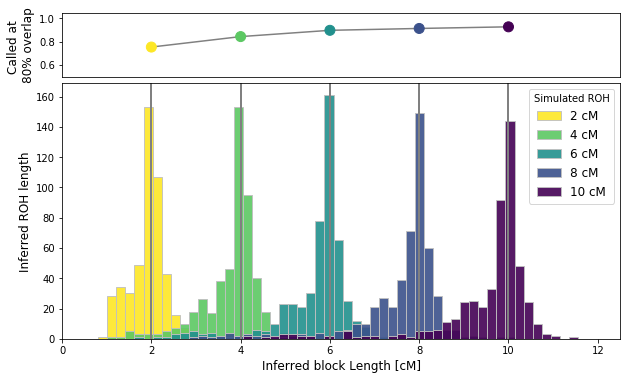

In [79]:
error_vec = np.logspace(-3,-1, 8)
error = error_vec[5]

output_prefix = ""  #"e01/" #"ROHin50/"
mosaic_folder = "./Simulated/1000G_Mosaic/CHB/"

bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

print(f"Showing Results for Error: {error:.4f} \n")
roh = Summary_ROH_Calls_Error(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, 
                              output_prefix = output_prefix, output=1, error=error)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus)

### Single Parameter Results for missing data


Showing Results for Missing: 0.5000
Total Nr Simulated: 500
Total Nr Called: 501
100 unique Individuals
500 / 500 Blocks called
497 Blocks called > 80.0 %
3.9754 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.1717
Bias: -0.0246
FP Blocks > 1 cM: 5
FP Blocks > 2 cM: 0
FP Blocks > 3 cM: 0
FP Blocks > 4 cM: 0
Total Nr Simulated: 500
Total Nr Called: 500
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 502
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 503


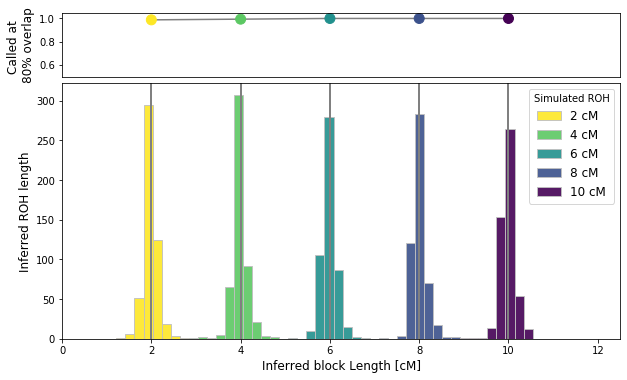

Analysis Complete


In [6]:
missing_vec = np.linspace(0.1, 1.0, 10)
m = missing_vec[4]

output_prefix = "diploidGT/" #"ROHin50/" /diploidGT
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"

bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

print(f"\nShowing Results for Missing: {m:.4f}")

###### Create the Wrapper Object
roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1, missing=m)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus)

## Plot FP as well as Power at 80 % (4 cM) as function of error

In [2]:
def load_fp_powers_error(roh, error_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(error_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(error_vec)), dtype="float") # Empty Array for Power   
    
    for i, error in enumerate(error_vec):
        print(f"Loading data for Error: {error:.4f}")
        roh.error = error
        roh.blen_cm=0  # Collect for bl 0
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers

def load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(missing_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(missing_vec)), dtype="float") # Empty Array for Power   
    
    for i, m in enumerate(missing_vec):
        print(f"Loading data for Missing: {m:.4f}")
        roh.missing = m
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "rc", output_prefix="", rd_digs=False):
    """Load False Positive Rates, as well as Power Curves for Different RC data
    base_path: The base path with which various RC 
    rc_vec: For which Readcounts to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]
    rd_digs: Whether to round the rc float to two relevants digits""" 
    fps = np.zeros(shape=(len(pw_lens), len(rc_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(rc_vec)), dtype="float") # Empty Array for Power   
    
    for i, rc in enumerate(rc_vec):
        if rd_digs:
            rc = f"{rc:.1f}"
        print(f"Loading data for mean RC: {rc} x")
        folder = base_path + rc_string + str(rc) + "/"
        roh = Summary_ROH_Calls(mosaic_folder=folder, ch=3, nr_iid = 100, blen_cm = 2, output_prefix = output_prefix, output=0)
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, power,
                         title="", savepath="", xlabel="Error Rate Target", xscale="log",
                         leg_loc="lower left", leg_loc1="upper right", ylim=[], ylim1=[],
                         height_ratios=[1,1], figsize=(6,6), fs = 14, nr_iid=100, ch_l=2.232549):
    """Plot False Positive rates as well as power against different error rates
    error_vec: Vector of Errors
    fps: List of false positive Call Numbers
    power: List of power fractions
    pw_lens: Lengths of the Power Cutoffs
    bl_lens: Lengths of Blocks simulated for power testing
    leg_loc(1): Position of the Legend (up and lower panel)
    nr_iid and ch_l: Nr individuals and length of Chromosome [M], need for FP Rate"""    
    ### Set the Colors
    cmap = cm.get_cmap("viridis_r")
    norm = plt.Normalize(1, np.max(bl_lens)) # Do the normalization
    colors = [cmap(norm(x)) for x in bl_lens]
    colors1 = [cmap(norm(x)) for x in pw_lens]

    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios)
    gs.update(hspace=0.05) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The lower subplot
    ax1 = plt.subplot(gs[1]) # The upper subplot
    
    for i in range(len(bl_lens)):
        ax.plot(error_vec, power[i,:], "o-", color = colors[i], label = f"{bl_lens[i]} cM")
    
    ax.set_ylabel("Fraction called \nwith 80% overlap", fontsize=fs)
    ax.set_xscale(xscale)
    ax.set_xticks([])
    ax.set_ylim([0,1])
    ax.legend(loc = leg_loc, title="Block Length", fontsize=fs*0.8)
    
    fps = fps / (nr_iid * ch_l) ### Normalize to Number per Morgan
    for i in range(len(pw_lens)):
        ax1.plot(error_vec, fps[i,:], "o-", color = colors1[i], label = f"> {pw_lens[i]} cM")
        #ax1.errorbar(error_vec, fps[i,:], yerr=np.sqrt(fps[i,:]))
    ax1.set_ylabel("# False Positives \nper Morgan", fontsize=fs)
    ax1.set_xscale(xscale)
    ax1.set_xlabel(xlabel, fontsize=fs)
    ax1.legend(loc = leg_loc1, title="Block Length", fontsize=fs*0.8)
    
    if len(ylim)>0:    # ylim of the upper panel 
        ax.set_ylim(ylim)
        
    if len(ylim1)>0:   # ylim of the lower panel
        ax1.set_ylim(ylim1)
        
    if len(title)>0:  # Set Title if given
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

# Plot varying Error Rates [Paper Main Figure]

In [55]:
%%time
### Load the Data
error_vec = np.logspace(-3,-1, 8)
output_prefix = "e01/" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6]
ch=3
nr_iid=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Error(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_error(roh, error_vec, bl_lens, pw_lens)

Loading data for Error: 0.0010
Loading data for Error: 0.0019
Loading data for Error: 0.0037
Loading data for Error: 0.0072
Loading data for Error: 0.0139
Loading data for Error: 0.0268
Loading data for Error: 0.0518
Loading data for Error: 0.1000
Successfully loaded complete data!
CPU times: user 41.5 s, sys: 2.79 s, total: 44.3 s
Wall time: 3min 26s


Successfully saved to ./figures/manuscript/power_test_TSI_PH.pdf


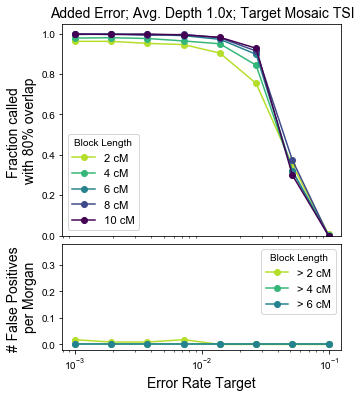

In [56]:
plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, powers, title="Added Error; Avg. Depth 1.0x; Target Mosaic TSI", 
                     savepath="./figures/manuscript/power_test_TSI_PH.pdf", 
                     leg_loc="lower left", leg_loc1="upper right", xlabel="Error Rate Target", xscale="log",
                     height_ratios=[2,1], ylim=[0, 1.05], ylim1=[-0.02, 0.38], figsize=(5,6))   
# "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

## Plot FP as well as 80 % Overlap Power for various Levels of Missingness [Paper]

In [35]:
%%time
### Load the Data
#missing_vec = np.linspace(0.1, 1.0, 10)
missing_vec = np.linspace(0.1, 0.5, 5)
output_prefix = "merged/" # "e01/" "diploidGT/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = n, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

Loading data for Missing: 0.1000
Loading data for Missing: 0.2000
Loading data for Missing: 0.3000
Loading data for Missing: 0.4000
Loading data for Missing: 0.5000
Loading data for Missing: 0.6000
Loading data for Missing: 0.7000
Loading data for Missing: 0.8000
Loading data for Missing: 0.9000
Loading data for Missing: 1.0000
Successfully loaded complete data!
CPU times: user 51.3 s, sys: 3 s, total: 54.3 s
Wall time: 3min 41s


Successfully saved to ./figures/manuscript/var_cov_Mosaic_TSI_PH.pdf


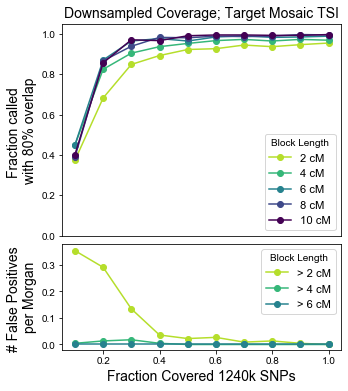

In [54]:
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, title="Downsampled Coverage; Target Mosaic TSI", 
                     savepath="./figures/manuscript/var_cov_Mosaic_TSI_PH.pdf", 
                     xlabel="Fraction Covered 1240k SNPs", xscale="linear",
                     leg_loc="lower right", leg_loc1="upper right", height_ratios=[2,1],
                     ylim=[0, 1.05], ylim1=[-0.02, 0.38], figsize=(5,6))   # "./figures_test/missing_01_powerfp_CHB.pdf"

## v2

In [6]:
%%time
### Load the Data
#missing_vec = np.linspace(0.1, 1.0, 10)
missing_vec = np.linspace(0.1, 0.5, 5)
output_prefix = "merged/" # "e01/" "diploidGT/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = n, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

Loading data for Missing: 0.1000
Loading data for Missing: 0.2000
Loading data for Missing: 0.3000
Loading data for Missing: 0.4000
Loading data for Missing: 0.5000
Successfully loaded complete data!
CPU times: user 23.2 s, sys: 1.14 s, total: 24.4 s
Wall time: 42 s


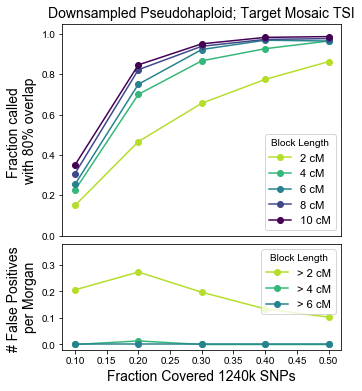

In [7]:
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, 
                     title="Downsampled Pseudohaploid; Target Mosaic TSI", 
                     savepath="", 
                     xlabel="Fraction Covered 1240k SNPs", xscale="linear",
                     leg_loc="lower right", leg_loc1="upper right", height_ratios=[2,1],
                     ylim=[0, 1.05], ylim1=[-0.02, 0.38], figsize=(5,6))   # "./figures_test/missing_01_powerfp_CHB.pdf"

## CHB Missing Data

In [12]:
%%time
### Load the Data
missing_vec = np.linspace(0.1, 1.0, 10)
#missing_vec = [0.1, 0.2]
output_prefix = "" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/CHB/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

Loading data for Missing: 0.1000
Loading data for Missing: 0.2000
Loading data for Missing: 0.3000
Loading data for Missing: 0.4000
Loading data for Missing: 0.5000
Loading data for Missing: 0.6000
Loading data for Missing: 0.7000
Loading data for Missing: 0.8000
Loading data for Missing: 0.9000
Loading data for Missing: 1.0000
Successfully loaded complete data!
CPU times: user 51.8 s, sys: 3.03 s, total: 54.8 s
Wall time: 4min 28s


In [ ]:
#title = "Target CHB - Lambda RC, HMM Read Error: 1%"
title = "Target CHB - Pseudohaploid, HMM Error: 0.1%"
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Coveage 1240k", xscale="linear")

## Plot the curves for Poisson RC data

In [17]:
%%time
rc_vec = np.linspace(0.1, 1, 10)
rc_vec = rc_vec[1:]
#rc_vec0 = np.linspace(2, 6, 5)
#rc_vec = [f"{m_rc:.1f}" for m_rc in rc_vec0]

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/CHB/"
output_prefix = "ROH1000/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=True)  # or rc for normal rc

Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.3 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 45.8 s, sys: 2.93 s, total: 48.7 s
Wall time: 3min 26s


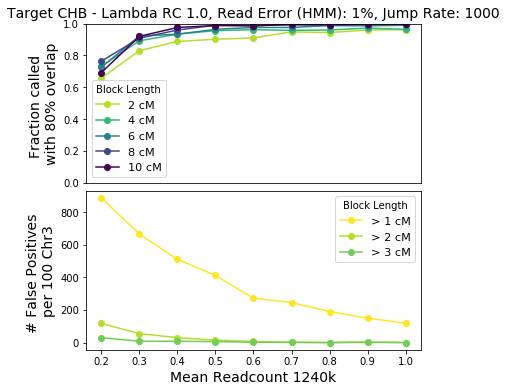

In [22]:
title = "Target CHB - Lambda RC 1.0, Read Error (HMM): 1%, Jump Rate: 1000"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", 
                     xlabel="Mean Readcount 1240k", xscale="linear")   # "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

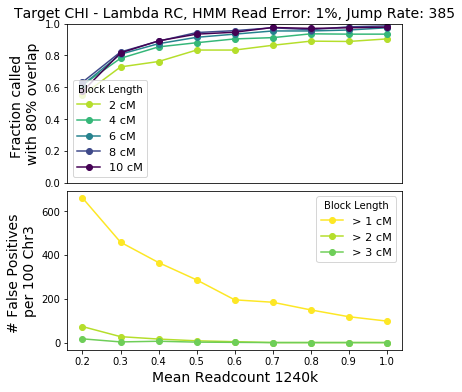

In [11]:
#title = "Target CHB - Lambda RC, HMM Read Error: 1%"
title = "Target CHI - Lambda RC, HMM Read Error: 1%, Jump Rate: 385"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", 
                     xlabel="Mean Readcount 1240k", xscale="linear")   # "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

### Plot downsampled Lambda Readcounts (0.1-1.0x) for TSI Mosaics

In [21]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 50.6 s, sys: 3.02 s, total: 53.7 s
Wall time: 3min 54s


In [ ]:
title = "HAPSBURG on TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Mean Readcount 1240k", xscale="linear", leg_loc="lower right", leg_loc1="upper right")

### Plot downsampled Lambda Readcounts (0.1-1.0x) for TSI Mosaics (allref with full 1000 Genome Haplotypes)
Supp. Fig. XX

In [54]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6, 8, 10] # Can do 1,2,3 as well
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "allref/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 50.6 s, sys: 3.04 s, total: 53.6 s
Wall time: 2min 30s


Successfully saved to ./figures/manuscript/supplement/downsampling_mosaic/hapsburg_allref.pdf


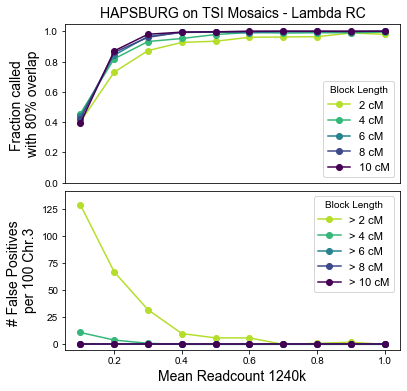

In [57]:
title = "HAPSBURG on TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     xlabel="Mean Readcount 1240k", xscale="linear", 
                     leg_loc="lower right", leg_loc1="upper right", 
                     ylim=[0, 1.05], ylim1=[-5, 142], 
                     savepath="./figures/manuscript/supplement/downsampling_mosaic/hapsburg_allref.pdf")

## Plot **bcftools** Lambda Readcount Curves

### 0.1-1.0x Coverage

In [58]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6, 8, 10]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "bcftools/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)  # or rc for normal rc

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 53.1 s, sys: 2.76 s, total: 55.9 s
Wall time: 1min 40s


Successfully saved to ./figures/manuscript/supplement/downsampling_mosaic/bcftools_default.pdf


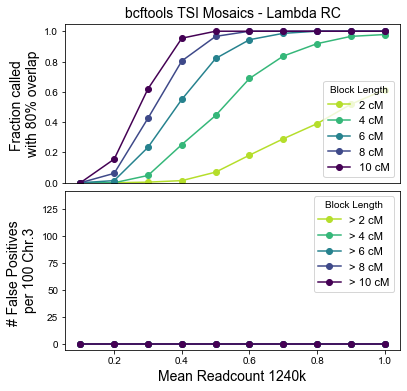

In [59]:
title = "bcftools TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     xlabel="Mean Readcount 1240k", xscale="linear", 
                     leg_loc="lower right", leg_loc1="upper right", 
                     ylim=[0, 1.05], ylim1=[-5, 142], 
                     savepath="./figures/manuscript/supplement/downsampling_mosaic/bcftools_default.pdf")

### BCFTOOLs with adjusted Parameters

In [66]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [2, 4, 6, 8, 10]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "bcftools100/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", 
                                output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 51.4 s, sys: 2.97 s, total: 54.4 s
Wall time: 1min 42s


Successfully saved to ./figures/manuscript/supplement/downsampling_mosaic/bcftools_adj.pdf


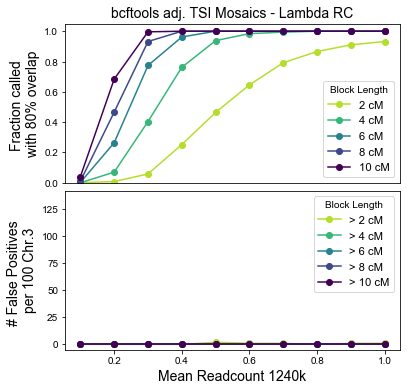

In [67]:
title = "bcftools adj. TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     xlabel="Mean Readcount 1240k", xscale="linear", 
                     leg_loc="lower right", leg_loc1="upper right", 
                     ylim=[0, 1.05], ylim1=[-5, 142], 
                     savepath="./figures/manuscript/supplement/downsampling_mosaic/bcftools_adj.pdf")

# Plot FP rate along genome

In [32]:
output_prefix = ""   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" diploidGT/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 0 # To show background rate
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1)
df_call_fp = roh.collect_fp_df()

### Load the Map Positions
path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv"
df_map = pd.read_csv(path_map, sep=",", header=None)  # Load the Meta File
map_pos = df_map[0].values

In [33]:
starts = df_call_fp["StartM"].values
ends = df_call_fp["EndM"].values

### Create the Binned Statistic
bins10 = np.arange(min(map_pos), max(map_pos), step=0.005)  # 0.1 cM Bins
counts = np.zeros(len(bins10), dtype="int")

for i in range(len(starts)):
    i1 = np.searchsorted(bins10, starts[i])
    i2 = np.searchsorted(bins10, ends[i])
    counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter

### Plot Counts False Positives and SNP density


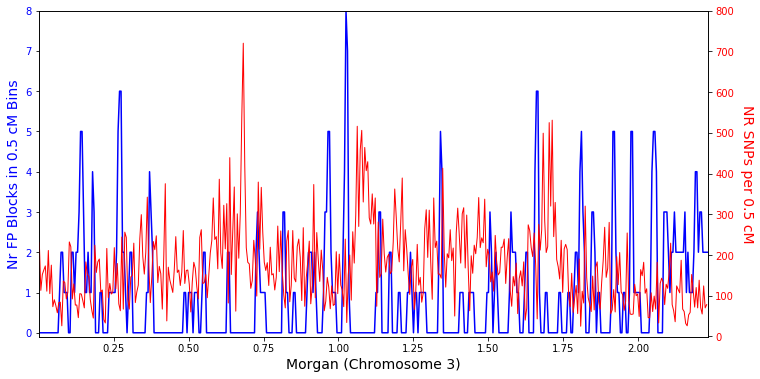

In [34]:
fs = 14

plt.figure(figsize=(12,6))
c1 = "blue"
c2 = "red"

ax = plt.gca()
ax.set_xlim((min(map_pos), max(map_pos)))
ax.plot(bins10, counts, color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax.set_ylim([-0.1, 8])
ax.set_ylabel("Nr FP Blocks in 0.5 cM Bins", fontsize=fs, color=c1)

ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
n, b = np.histogram(map_pos, bins = bins10)
x = (b[1:] + b[:-1]) / 2

ax1.plot(x, n, color=c2, linewidth=1.0)
ax1.tick_params(axis='y', labelcolor=c2)
ax1.set_ylim([-1, 800])
ax1.set_ylabel("NR SNPs per 0.5 cM", color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)


ax.set_xlabel("Morgan (Chromosome 3)", fontsize=fs)
plt.show()

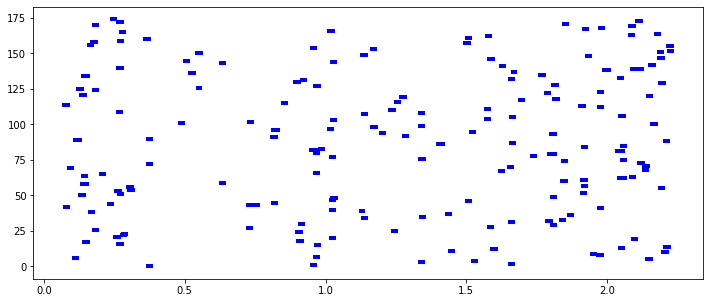

In [35]:
plt.figure(figsize=(12,5))
for i in range(len(df_call_fp)):
    plt.plot([starts[i], ends[i]], [i,i], linewidth=4, color="blue")
plt.show()

# Area 51